In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [ ]:
wid = 64
oversample = 4

nwavels = 20#20
npoly=nwavels

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

In [4]:
exposures = [
    BlankExposure("test", "F110W", SinglePointSpectrumFit(nwavels))
] 

In [5]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.5,-0.6])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = 3.45

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.asarray([1.6117526, 1.630006 , 1.7464325, 1.7394772, 1.8483782, 1.9626302,
         2.0166223, 2.054695 , 2.1089914, 2.2015576, 2.2763495, 2.3084195,
         2.2964146, 2.3258219, 2.3839521, 2.354199 , 2.3219314, 2.3110254,
         2.3895059, 2.0729065])#np.asarray([1.,0.,1.,0.,1.,0.,1.,0.,1.])+1#jr.uniform(jr.key(1), (nwavels,), minval=-1, maxval=1)#.at[0].set(1)

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)
    

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

injected_model = set_array(NICMOSModel(exposures, params, optics, detector))

injected_params = ModelParams(params)

In [6]:
injected_params.get("spectrum")

{'test_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)}

In [7]:
exposures = [
    #InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e-3, 10)
    InjectedExposure("test", 'F110W', SinglePointSpectrumFit(nwavels), injected_model, 287*1e10, 10)
]

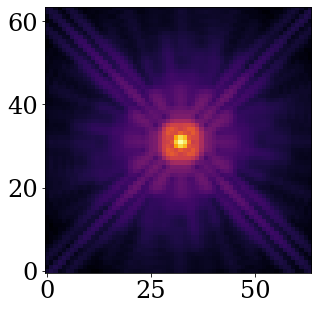

In [8]:
plt.imshow(exposures[0].data**0.125)

In [9]:
#potato

In [10]:
exposures[0].filter

'F110W'

In [11]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

32 31


In [12]:
exposures[0].filter

'F110W'

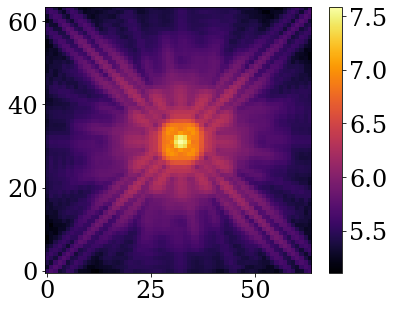

In [13]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

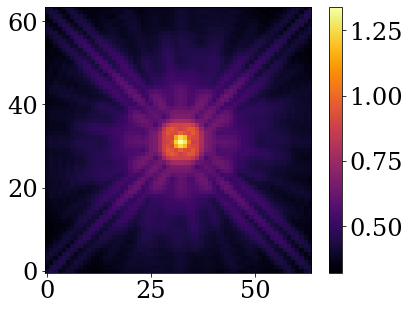

In [14]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [15]:
params = {
    "fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))

    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(nwavels)#*10

    #params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.ones(npoly)#.at[0].set(1)


    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [16]:
model_forecast = injected_params.inject(model)
rc = True
fishers = calc_fishers(model_forecast, exposures, ["spectrum"], recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
fishers

{'test_F110W': {'spectrum': Array([[9.3587686e+14, 8.6745642e+14, 8.3938036e+14, 7.7652854e+14,
          7.1759817e+14, 6.6537714e+14, 6.3392563e+14, 6.3242977e+14,
          6.4533863e+14, 6.8771392e+14],
         [8.6745609e+14, 8.6947150e+14, 8.5682148e+14, 7.8590265e+14,
          7.2968555e+14, 6.8408293e+14, 6.4911156e+14, 6.2829050e+14,
          6.3487374e+14, 6.8117262e+14],
         [8.3938022e+14, 8.5682141e+14, 9.3468568e+14, 8.5216513e+14,
          7.5459965e+14, 6.8293309e+14, 6.3217872e+14, 5.9916404e+14,
          5.9056612e+14, 6.4767986e+14],
         [7.7652828e+14, 7.8590258e+14, 8.5216513e+14, 8.9880687e+14,
          8.1113135e+14, 7.1923073e+14, 6.5588633e+14, 6.1907249e+14,
          6.0696511e+14, 6.5143299e+14],
         [7.1759790e+14, 7.2968568e+14, 7.5459998e+14, 8.1113169e+14,
          8.5626347e+14, 7.9040558e+14, 7.1132745e+14, 6.6500958e+14,
          6.4655800e+14, 6.7455220e+14],
         [6.6537700e+14, 6.8408300e+14, 6.8293302e+14, 7.1923100e+14,

In [18]:
np.real(np.linalg.eig(fishers['test_F110W']['spectrum'])[0].sort()[::-1])

Array([7.3508784e+15, 8.7316746e+14, 3.3528286e+14, 1.3840302e+14,
       9.8051889e+13, 5.8586311e+13, 3.1797501e+13, 2.3798965e+13,
       1.6125509e+13, 1.0692886e+13], dtype=float32)

Text(0, 0.5, 'Eigenvalue')

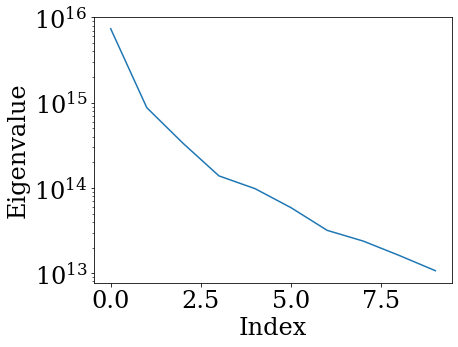

In [19]:
plt.semilogy(np.real(np.linalg.eig(fishers['test_F110W']['spectrum'])[0].sort()[::-1]))
plt.xlabel("Index")
plt.ylabel("Eigenvalue")

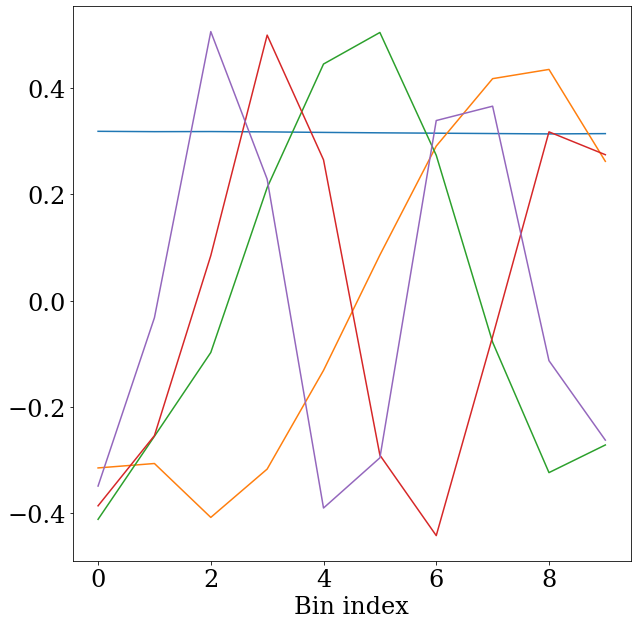

In [20]:
vals, vects = np.linalg.eig(fishers['test_F110W']['spectrum'])

order = np.argsort(vals)[::-1]

plt.figure(figsize=(10,10))
plt.xlabel("Bin index")

for i in range(5):
    plt.plot(np.real(vects[:,order[i]]))

In [21]:
stop

NameError: name 'stop' is not defined

In [ ]:
print(params.params)

{'fluxes': {'test_F110W': Array(2.7175505, dtype=float32)}, 'positions': {'test_F110W': Array([0., 0.], dtype=float32)}, 'spectrum': {'test_F110W': Array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)}, 'aberrations': {'test_F110W': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'cold_mask_shift': {'global': Array([6., 6.], dtype=float32)}, 'cold_mask_rot': {'global': -45.0}, 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F110W': -45.0}, 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0432, 'rot': 0.0, 'softening': 2.0}


In [ ]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*100, 120),
    #"cold_mask_scale": opt(g*1000, 150),
    #"cold_mask_shear": opt(g*10, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*1.5,120),
    "spectrum": opt(g*50, 20),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [ ]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [ ]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
fishers

{'test_F110W': {'fluxes': Array([[0.]], dtype=float32),
  'positions': Array([[ 2.5005181e+09, -3.5338298e+08],
         [-3.5338310e+08,  2.7121820e+09]], dtype=float32),
  'cold_mask_shift': Array([[ 3.0236336e+08, -3.0113454e+07],
         [-3.0113462e+07,  3.0240582e+08]], dtype=float32),
  'cold_mask_rot': Array([[5.3550694e+08]], dtype=float32),
  'aberrations': Array([[-1.73064199e+04,  8.24520264e+02,  1.19573865e+03,
           8.41650098e+03, -7.91399463e+03,  1.67327686e+03,
           3.26642090e+03,  7.95437842e+03,  1.57259058e+03,
          -1.02827307e+03, -3.55723755e+03, -4.22944794e+02,
          -1.47819346e+04,  1.47700703e+04, -2.02298669e+03,
          -2.35743237e+03,  1.42817261e+03, -1.30090369e+03,
           2.23764434e+04, -2.34708569e+03, -5.54669617e+02,
          -1.58495087e+02,  5.03496729e+03,  2.67083740e+03,
           4.63121613e+02, -5.36405762e+03],
         [ 8.24570251e+02, -2.53598887e+04,  7.37151184e+02,
          -5.81396045e+03,  6.0275844

In [ ]:
lrs.params

{'aberrations': {'test_F110W': Array([ 5.77820247e-05,  3.94323506e-05,  2.68242711e-05, -1.58460771e-05,
         -1.54501486e-05, -8.50175638e-06, -8.65428956e-06, -2.60590285e-04,
          3.17563645e-05,  4.16967450e-05,  9.68620370e-05,  7.16969662e-05,
         -2.56515359e-05, -2.83305453e-05, -1.25911729e-05, -1.23229120e-05,
         -2.05567394e-05, -2.09584905e-05,  7.34474161e-05,  4.82249634e-05,
          3.72724899e-05,  4.05813371e-05,  7.67035526e-05,  1.94058186e-04,
          1.15978466e-04, -1.02578109e-04], dtype=float32)},
 'cold_mask_rot': {'global': Array(-1.8673894e-09, dtype=float32)},
 'cold_mask_scale': {'F110W': None},
 'cold_mask_shear': {'F110W': None},
 'cold_mask_shift': {'global': Array([-3.3072791e-09, -3.3068146e-09], dtype=float32)},
 'fluxes': {'test_F110W': Array(1., dtype=float32)},
 'outer_radius': None,
 'positions': {'test_F110W': Array([-3.9991713e-10, -3.6870682e-10], dtype=float32)},
 'primary_rot': {'F110W': None},
 'primary_scale': {'F11

In [ ]:
model

NICMOSModel(
  params={
    'aberrations':
    {'test_F110W': f32[26]},
    'cold_mask_rot':
    {'global': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'global': f32[2]},
    'fluxes':
    {'test_F110W': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'test_F110W': f32[2]},
    'primary_rot':
    {'F110W': f32[]},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'rot':
    f32[],
    'scale':
    f32[],
    'secondary_radius':
    f32[],
    'softening':
    f32[],
    'spectrum':
    {'test_F110W': f32[9]},
    'spider_width':
    f32[]
  },
  filters={'F110W': f32[244,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None,
          rotation=f32[],
          compression=None,
       

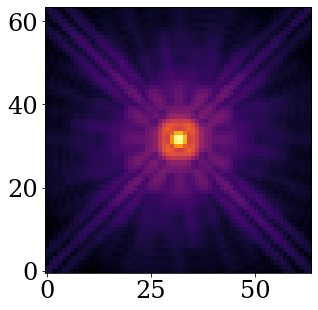

In [ ]:
plt.imshow(exposures[0].fit(model,exposures[0])**0.125)

In [ ]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(300)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)
    
    #if i == 200:
    #    params.set("softening", 0.2)

    #params = params.set("spectrum.U10764_F110W", params.get("spectrum.U10764_F110W")/np.sum(params.get("spectrum.U10764_F110W")))

    models.append(params)
    losses.append(loss)


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
#model


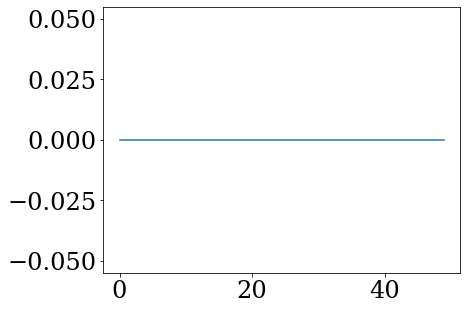

In [ ]:
plt.plot(losses[-50:])

6


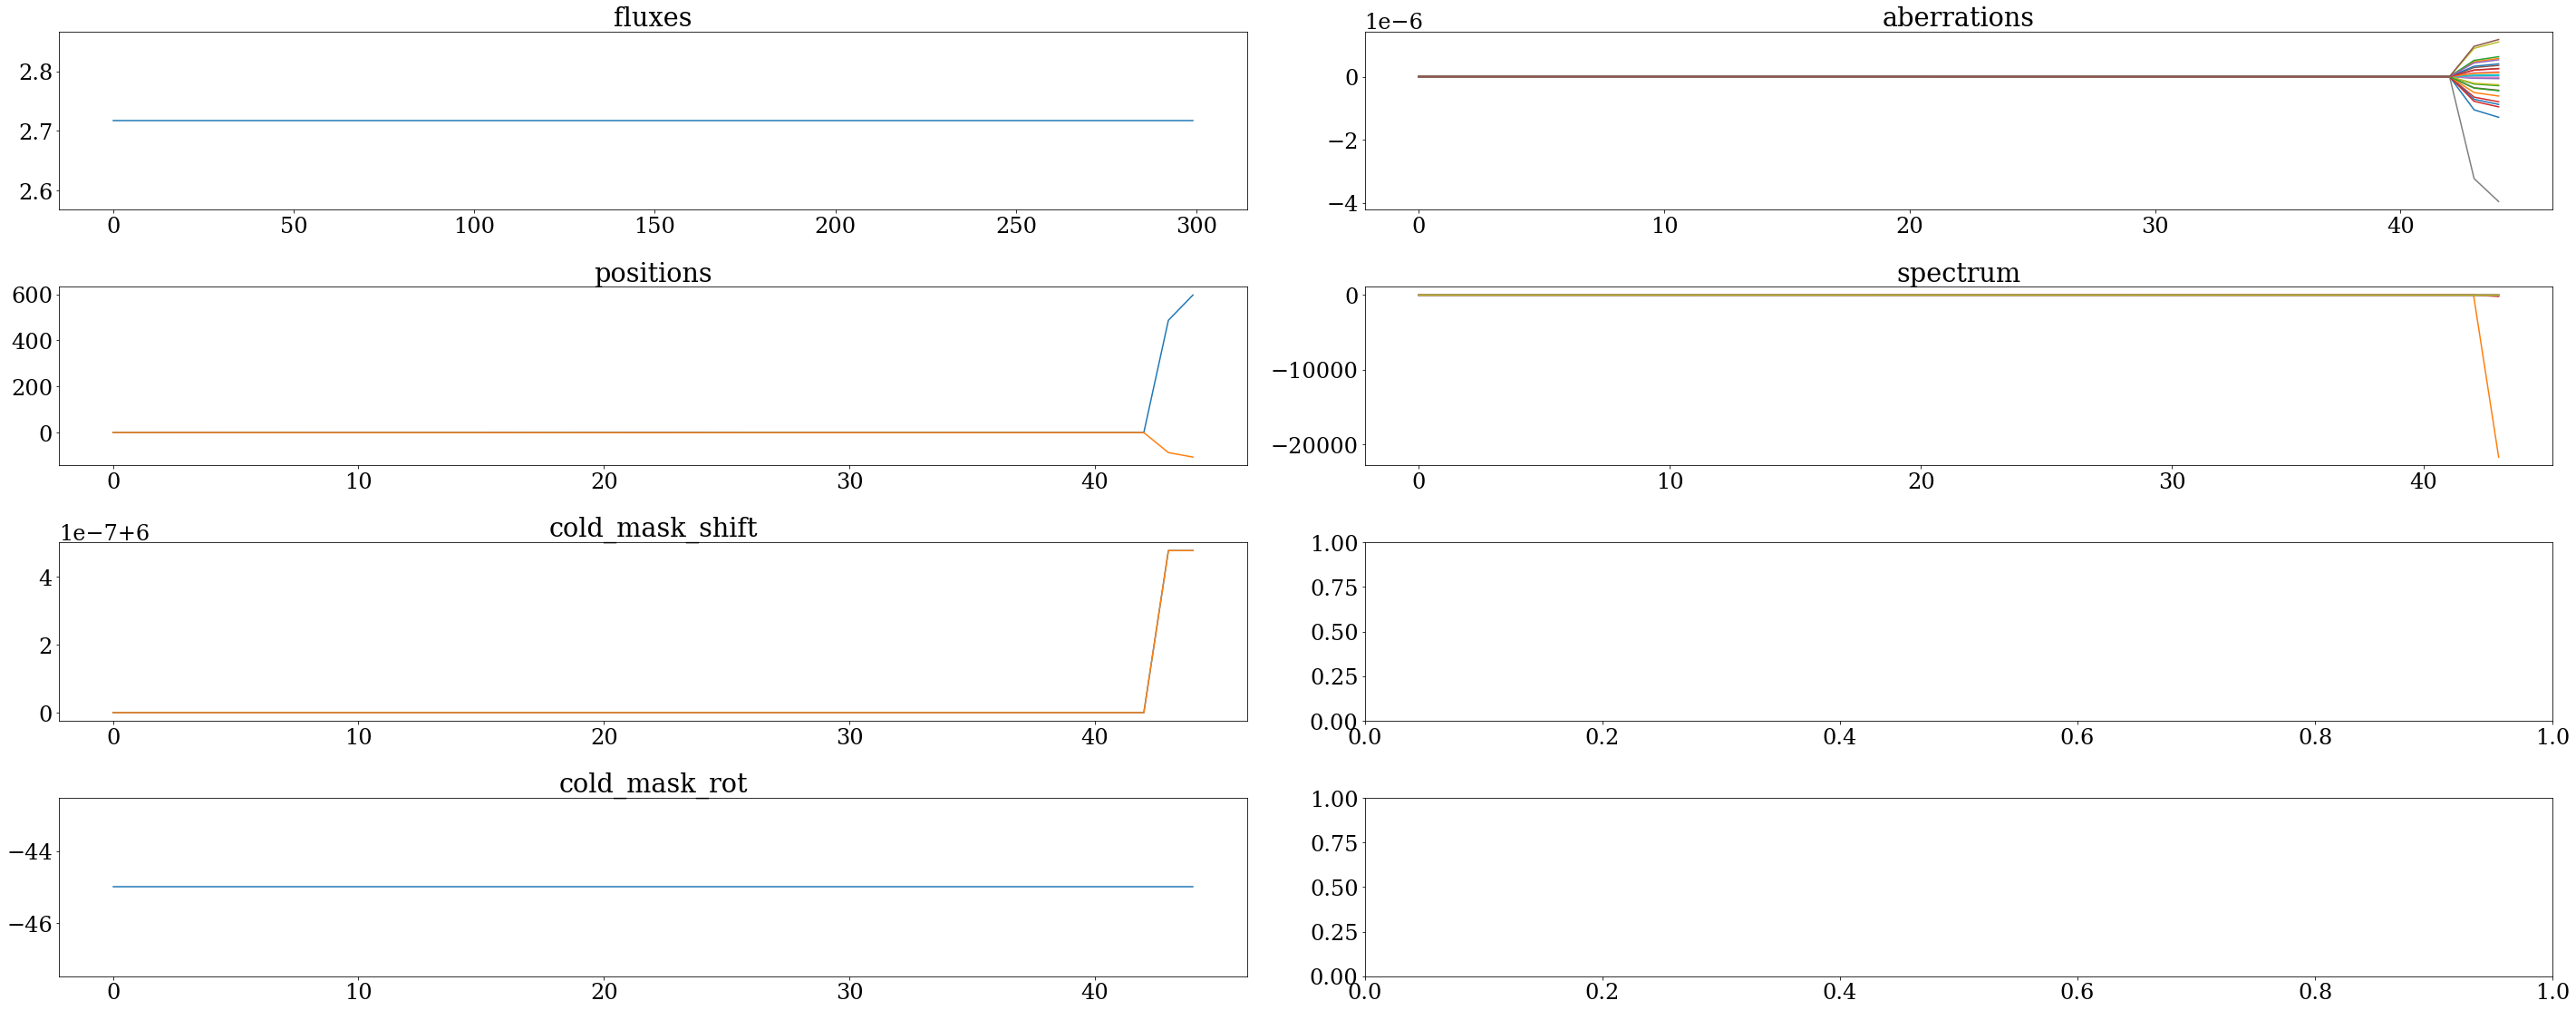

In [ ]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing", "slope", "spectrum"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

In [ ]:
#for exp in exposures:
#    params = params.set("aberrations."+exp.fit.get_key(exp, "aberrations"), -params.get("aberrations."+exp.fit.get_key(exp, "aberrations")))

2.654884e+10, 0.000000e+00


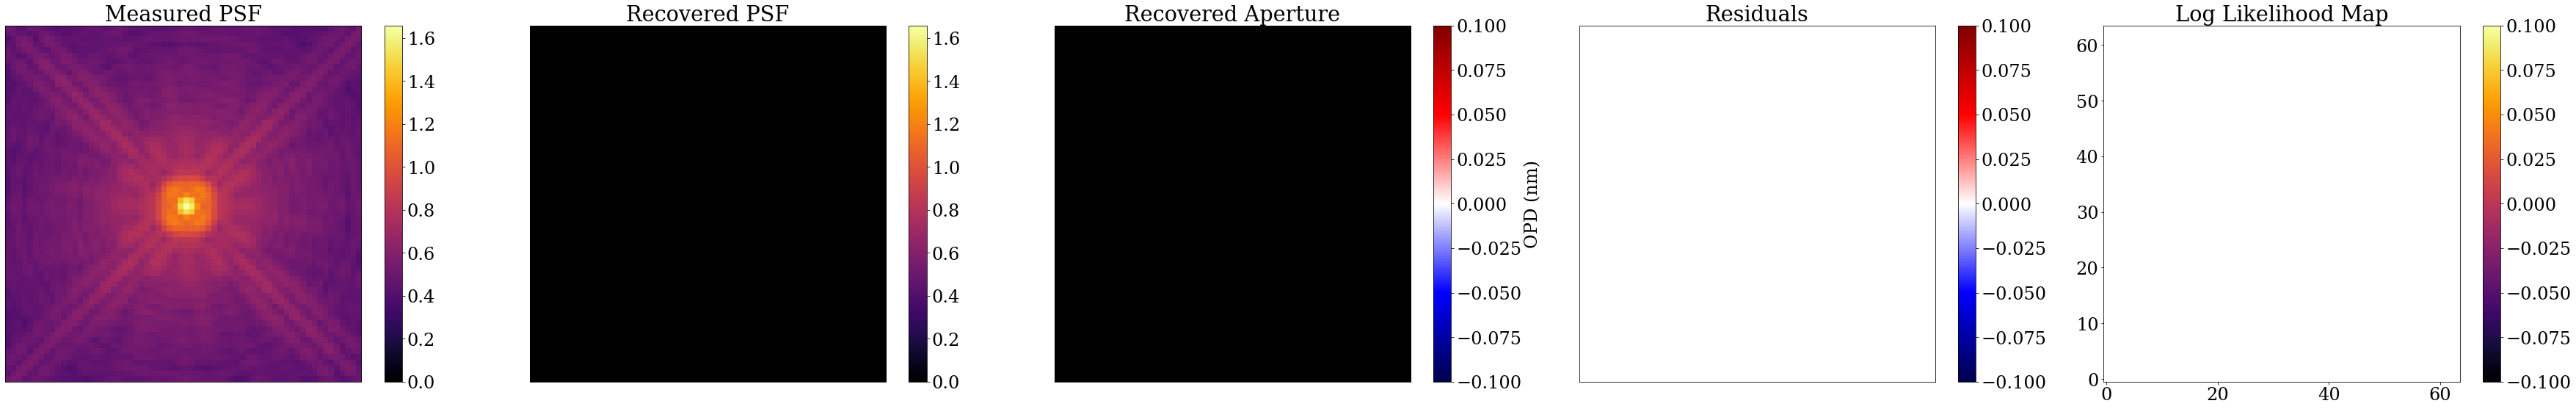

In [ ]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]


model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[3].axvline((wid-1)/2 + params.get(exp.map_param("positions"))[0], color='k',linestyle='--')
axs[3].axhline((wid-1)/2 + params.get(exp.map_param("positions"))[1], color='k',linestyle='--')


lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [ ]:
params.get("spectrum.test_F110W")

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [ ]:
"""wv = filter_files["F110W"][:,0]/1e10
wmax = np.max(wv)
wmin = np.min(wv)

swv = (wv-wmin)/(wmax-wmin)
spec = dl.PolySpectrum(swv, params.get("spectrum.test_F110W"))
ipec = dl.PolySpectrum(swv, injected_params.get("spectrum.test_F110W"))

plt.plot(swv, spec.weights)
plt.plot(swv, ipec.weights)"""

'wv = filter_files["F110W"][:,0]/1e10\nwmax = np.max(wv)\nwmin = np.min(wv)\n\nswv = (wv-wmin)/(wmax-wmin)\nspec = dl.PolySpectrum(swv, params.get("spectrum.test_F110W"))\nipec = dl.PolySpectrum(swv, injected_params.get("spectrum.test_F110W"))\n\nplt.plot(swv, spec.weights)\nplt.plot(swv, ipec.weights)'

In [ ]:
params.params["spectrum"]

{'test_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)}

In [ ]:
#potato

In [ ]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
fishers.keys()

dict_keys(['test_F110W'])

In [ ]:
#plt.imshow(fishers['test_F110W']['spectrum'], cmap='seismic')

In [ ]:
spectrum_cov = np.linalg.inv(fishers['test_F110W']['spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

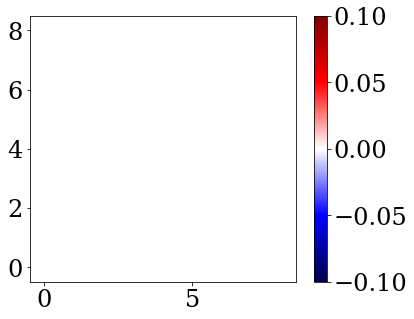

In [ ]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()

In [ ]:
params.params['spectrum']

{'test_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)}

In [ ]:
params.get("spectrum.test_F110W")/spectrum_err

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [ ]:
params.params

{'aberrations': {'test_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],      dtype=float32)},
 'cold_mask_rot': {'global': Array(nan, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'global': Array([nan, nan], dtype=float32)},
 'fluxes': {'test_F110W': Array(2.7175505, dtype=float32)},
 'outer_radius': 1.146,
 'positions': {'test_F110W': Array([nan, nan], dtype=float32)},
 'primary_rot': {'F110W': -45.0},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'rot': 0.0,
 'scale': 0.0432,
 'secondary_radius': 0.44639999999999996,
 'softening': 2.0,
 'spectrum': {'test_F110W': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)},
 'spider_width': 0.0924}

Text(0, 0.5, 'Relative Spectral Intensity')

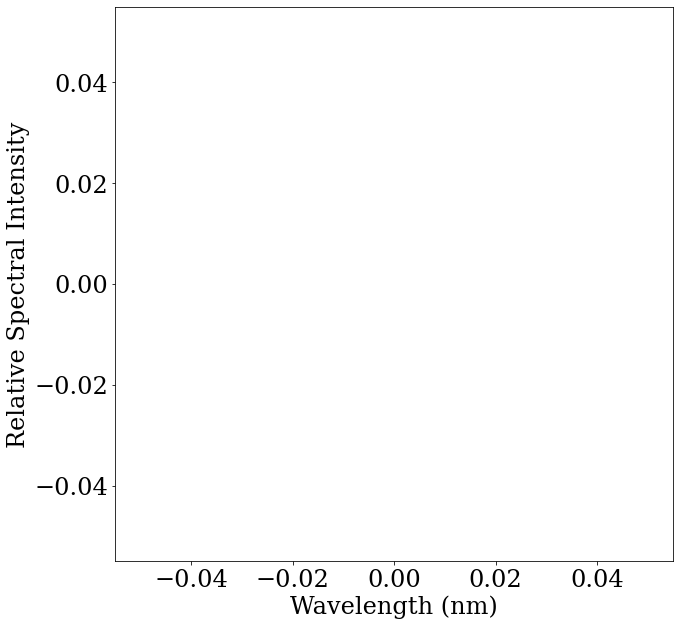

In [ ]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = (wmax-wmin)*0.1

wavels = np.linspace(wmin+woff, wmax-woff, nwavels)
#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.errorbar(wavels[:], params.get("spectrum.test_F110W")[:], yerr = spectrum_err[:])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [ ]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [ ]:
import numpy

symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

coeffs = numpy.random.multivariate_normal(params.get("spectrum.test_F110W"), nearestPD(symmetric_cov))

LinAlgError: SVD did not converge

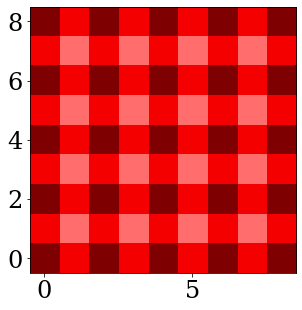

In [ ]:
pdc = nearestPD(symmetric_cov)
plt.imshow(pdc, cmap='seismic', vmin=-np.max(np.abs(pdc)), vmax=np.max(np.abs(pdc)))


/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_33150/1230687083.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeffs = numpy.random.multivariate_normal(params.get("spectrum.test_F110W"), nearestPD(symmetric_cov))


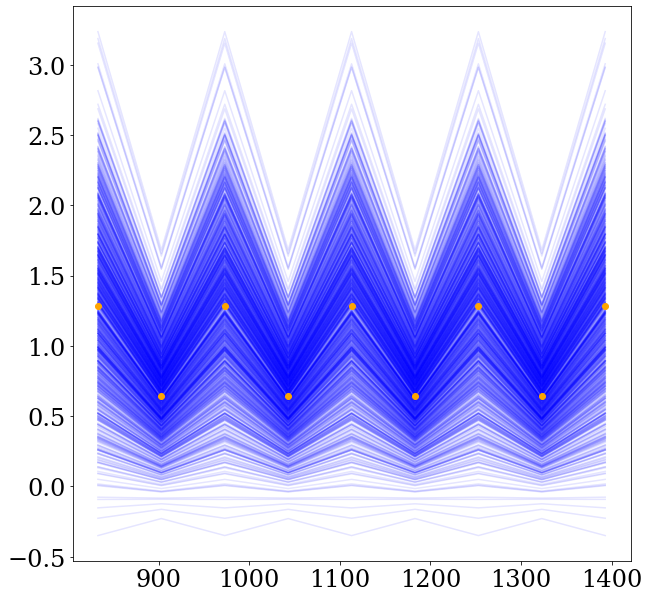

In [ ]:
plt.figure(figsize=(10,10))
swv = filter_files["F110W"][:,0]/10
wmin = np.min(swv)
wmax = np.max(swv)
woff = (wmax-wmin)*0.1
wavels = np.linspace(wmin+woff, wmax-woff, nwavels)

for i in range(1000):
    coeffs = numpy.random.multivariate_normal(params.get("spectrum.test_F110W"), nearestPD(symmetric_cov))
    plt.plot(wavels, coeffs, color='b', alpha=0.1, zorder=0)

plt.scatter(wavels, params.get("spectrum.test_F110W"), color="orange", zorder=1)


In [ ]:
params.get("spectrum.test_F110W")

Array([1.2812426 , 0.6406618 , 1.2812485 , 0.6406086 , 1.2813101 ,
       0.64063764, 1.2812119 , 0.64067954, 1.2812105 ], dtype=float32)

In [ ]:
spectrum_cov

Array([[0.19600208, 0.09800901, 0.19600214, 0.09799934, 0.1960116 ,
        0.0980048 , 0.19599254, 0.09801888, 0.19599232],
       [0.09800922, 0.04900857, 0.09800927, 0.04900378, 0.09801398,
        0.04900648, 0.09800442, 0.04901351, 0.09800436],
       [0.196002  , 0.09800895, 0.19600199, 0.09799925, 0.19601145,
        0.09800471, 0.19599235, 0.0980188 , 0.19599214],
       [0.09799944, 0.04900371, 0.09799949, 0.04899887, 0.09800421,
        0.0490016 , 0.09799466, 0.04900863, 0.09799458],
       [0.19601147, 0.09801367, 0.19601148, 0.09800401, 0.19602095,
        0.09800946, 0.19600186, 0.09802355, 0.19600165],
       [0.09800501, 0.04900649, 0.09800505, 0.04900165, 0.09800977,
        0.04900438, 0.09800022, 0.04901142, 0.09800014],
       [0.19599193, 0.09800392, 0.19599198, 0.09799425, 0.19600143,
        0.09799971, 0.19598235, 0.09801377, 0.19598216],
       [0.09801953, 0.04901374, 0.09801956, 0.04900891, 0.09802429,
        0.04901164, 0.09801472, 0.04901869, 0.09801463],


In [ ]:
len(swv)

71